In [5]:
import pandas as pd
from jupyter_server.utils import fetch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
from catboost import cv, Pool, CatBoostClassifier

In [6]:
RANDOM_STATE = 42
K_FOLDS = 5
RESULT_PATH = "../results/"
RESULT_FINE_NAME = "model_comparison_results."
RESULT_FINE_EXT = "csv"
DATASET_PATH = "../data/Telco-Customer-Churn.csv"

In [7]:
def load_and_preprocess(
    filepath: str,
    drop_aux=False,
    encode_binary=False,
    map_gender=False,
    one_hot_encoding=False,
    scale_numeric=False,
    to_numeric=False,
    encode_target=True,
) -> pd.DataFrame:
    churn_df = pd.read_csv(filepath)
    if drop_aux:
        # Drop customerID
        churn_df = churn_df.drop(columns=["customerID"])

    if to_numeric:
        # Convert TotalCharges to numeric and drop missing values
        churn_df["TotalCharges"] = pd.to_numeric(
            churn_df["TotalCharges"], errors="coerce"
        )
        churn_df = churn_df.dropna(subset=["TotalCharges"])

    if encode_binary:
        # Encode binary features
        binary_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling"]
        for col in binary_cols:
            churn_df[col] = churn_df[col].map({"Yes": 1, "No": 0})

    if encode_target:
        # Encode target variable
        churn_df["Churn"] = churn_df["Churn"].map({"Yes": 1, "No": 0})

    if map_gender:
        # Map gender
        churn_df["gender"] = churn_df["gender"].map({"Male": 1, "Female": 0})

    if one_hot_encoding:
        # One-hot encode remaining categorical variables
        categorical_cols = churn_df.select_dtypes(include=["object"]).columns.tolist()
        churn_df = pd.get_dummies(churn_df, columns=categorical_cols, drop_first=True)

    if scale_numeric:
        # Scale numeric features
        numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
        scaler = StandardScaler()
        churn_df[numeric_cols] = scaler.fit_transform(churn_df[numeric_cols])

    return churn_df

In [8]:
df = load_and_preprocess(
    filepath=DATASET_PATH,
    drop_aux=True,
    encode_binary=False,
    map_gender=False,
    one_hot_encoding=False,
    scale_numeric=True,
    to_numeric=True,
    encode_target=True,
)


In [9]:
cat_features = df.select_dtypes(include=["object"]).columns.tolist()

In [10]:
X = df.drop("Churn", axis=1)
y = df["Churn"]
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE
)

In [11]:
params = {
    "iterations": 500,
    "learning_rate": 0.1,
    "depth": 6,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_seed": 42,
    "cat_features": cat_features,
    "verbose": False,
}

In [12]:
train_pool = Pool(X_train_cat, y_train_cat, cat_features=cat_features)
test_pool = Pool(X_test_cat, y_test_cat, cat_features=cat_features)

In [13]:
cv_results = cv(
    params=params, pool=train_pool, fold_count=K_FOLDS, verbose=False, plot=True
)
print("\nCV Results Summary (last few rows):")
print(cv_results.tail())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.840363763
bestIteration = 142

Training on fold [1/5]

bestTest = 0.8640524914
bestIteration = 204

Training on fold [2/5]

bestTest = 0.8497878319
bestIteration = 109

Training on fold [3/5]

bestTest = 0.8454857596
bestIteration = 63

Training on fold [4/5]

bestTest = 0.8453784609
bestIteration = 71


CV Results Summary (last few rows):
     iterations  test-AUC-mean  test-AUC-std  test-Logloss-mean  \
495         495       0.838174      0.012261           0.435236   
496         496       0.838161      0.012312           0.435313   
497         497       0.838131      0.012306           0.435404   
498         498       0.838066      0.012373           0.435487   
499         499       0.838153      0.012266           0.435504   

     test-Logloss-std  train-Logloss-mean  train-Logloss-std  
495          0.018683            0.231734           0.002618  
496          0.018811            0.231511           0.002631  
497          0.018798        

In [14]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [1, 3, 5],
    "early_stopping_rounds": [25, 50, 100],
}
catboost = CatBoostClassifier(
    iterations=cv_results["test-AUC-mean"].idxmax(),
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=RANDOM_STATE,
    verbose=False,
)
grid_search = GridSearchCV(
    catboost, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=2
)
grid_search.fit(X_train_cat, y_train_cat, cat_features=cat_features)
print("Best Parameters:", grid_search.best_params_)
final_catboost_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.05; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.05; total time=   0.2s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.05; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=1, learning_rate=0.05; total time=   0.3s
[CV] END depth=4, early_stopping_rounds=25, l2_leaf_reg=

In [17]:
trained_models = {}
results = {}
final_catboost_model.fit(train_pool, eval_set=test_pool)
trained_models["CatBoost"] = {}
trained_models["CatBoost"]["model"] = final_catboost_model

In [18]:
catboost_y_pred = final_catboost_model.predict(X_test_cat)
cat_boost_y_proba = final_catboost_model.predict_proba(X_test_cat)[:, 1]

results["CatBoost"] = {
    "accuracy": accuracy_score(y_test_cat, catboost_y_pred),
    "precision": precision_score(y_test_cat, catboost_y_pred),
    "recall": recall_score(y_test_cat, catboost_y_pred),
    "f1_score": f1_score(y_test_cat, catboost_y_pred),
    "roc_auc": roc_auc_score(y_test_cat, cat_boost_y_proba),
    "cm": confusion_matrix(y_test_cat, catboost_y_pred),
}
trained_models["CatBoost"]["ypp"] = cat_boost_y_proba
trained_models["CatBoost"]["y_test"] = y_test_cat
trained_models["CatBoost"]["X_test"] = X_test_cat

In [19]:
results["CatBoost"]

{'accuracy': 0.8038379530916845,
 'precision': 0.6633333333333333,
 'recall': 0.5320855614973262,
 'f1_score': 0.5905044510385756,
 'roc_auc': 0.8415613627304306,
 'cm': array([[932, 101],
        [175, 199]])}

<Figure size 1200x600 with 0 Axes>

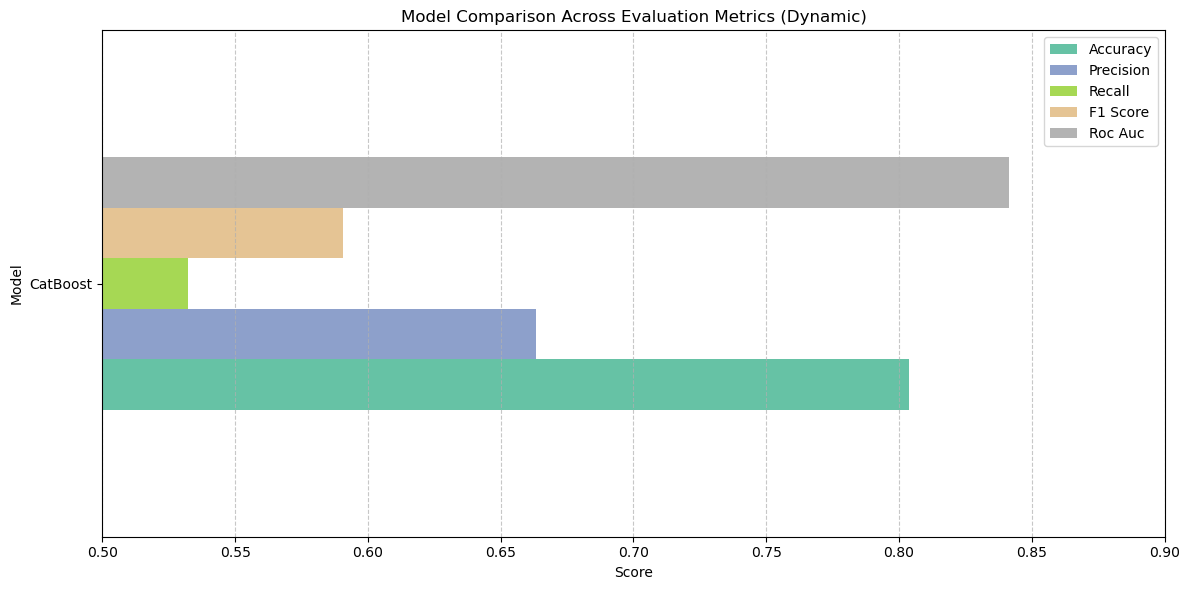

In [20]:
dynamic_df = pd.DataFrame.from_dict(results, orient="index")

dynamic_df.columns = [col.replace("_", " ").title() for col in dynamic_df.columns]
dynamic_df.index.name = "Model"

plt.figure(figsize=(12, 6))
dynamic_df.plot(kind="barh", figsize=(12, 6), colormap="Set2")
plt.title("Model Comparison Across Evaluation Metrics (Dynamic)")
plt.xlabel("Score")
plt.xlim(0.5, 0.9)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()